# Import des librairies

In [1]:
#Main libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import datetime

In [2]:
#Embeddings

from sentence_transformers import util, SentenceTransformer

In [3]:
#deep learning

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

In [4]:
#Classifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [5]:
#Model selection

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from IPython.display import display

In [6]:
#BERT for Sequence Classification

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

# Import des données

In [7]:
data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [8]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
data.shape

(7613, 5)

In [10]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Split training data and validation data

In [11]:
train_data, val_data = train_test_split(data, test_size=0.1)

In [12]:
train_data.shape

(6851, 5)

In [13]:
val_data.shape

(762, 5)

### Resetting index

In [14]:
train_data.reset_index(drop=True, inplace=True)

In [15]:
train_data.head()

,id,keyword,location,text,target
0,524,army,Campinas Sp,You da One \n\n#MTVSummerStar #VideoVeranoMTV ...,0
1,2795,curfew,HTX,You got a whole curfew ????,0
2,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1
3,826,battle,Australia,#LonePine remembered around Australia as 'desc...,0
4,657,attack,Freeport IL. USA,Horrific attack on wife by muslim in Italy htt...,1


In [16]:
val_data.reset_index(drop=True, inplace=True)

### Separating X and target

In [17]:
X_train = train_data['text']

In [18]:
y_train = train_data['target']

In [19]:
X_val = val_data['text']

In [20]:
y_val = val_data['target']

# Data Engineering

In [21]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
data.keyword.isna().sum()

61

In [23]:
data.location.isna().sum()

2533

In [24]:
l_full_text = []

for i in range(data.shape[0]):
    full_text = data['text'][i]
    if str(data['keyword'][i]) != 'nan':
        full_text += f' #{data["keyword"][i]}'
    if str(data['location'][i]) != 'nan':
        full_text += f' #{data["location"][i]}'

    l_full_text.append(full_text)

In [25]:
data['full_text'] = pd.Series(l_full_text)

In [26]:
data.head()

,id,keyword,location,text,target,full_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


Après quelques essais, les embeddings de full_text offrent de moins bons résultats de prédiction que ceux du texte simple.

# Sentence Embeddings

In [27]:
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [28]:
embeddings = transformer.encode(X_train)

In [29]:
embeddings.shape

(6851, 768)

In [30]:
val_embeddings = transformer.encode(X_val)

# Deep Learning Model

### Convert embeddings and target to tensors

In [31]:
tensor_embeddings = tf.convert_to_tensor(embeddings)
tensor_y = tf.convert_to_tensor(y_train)

Metal device set to: Apple M1


2022-08-30 15:20:23.061156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-30 15:20:23.061758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
tensor_embeddings.shape

TensorShape([6851, 768])

In [33]:
tensor_y.shape

TensorShape([6851])

In [34]:
tensor_val_embeddings = tf.convert_to_tensor(val_embeddings)
tensor_val_y = tf.convert_to_tensor(y_val)

### Define model architecture

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [36]:
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

In [37]:
model = Sequential()

# Define model architecture.
model.add(Dense(728, input_shape=(768,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 728)               559832    
                                                                 
 dropout (Dropout)           (None, 728)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               186624    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [39]:
model.compile(
    optimizer=optimizer, #or optimizer
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

### Training and performances visualization

In [40]:
history = model.fit(
    x=tensor_embeddings,
    y=tensor_y,
    validation_data=(tensor_val_embeddings, tensor_val_y),
    callbacks=[learning_rate_reduction],
    epochs = 20)

Epoch 1/20


2022-08-30 15:20:23.562368: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-30 15:20:24.113247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8098

2022-08-30 15:20:29.837677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 7s 27ms/step - loss: 0.4488 - accuracy: 0.8098 - val_loss: 0.4591 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 6s 29ms/step - loss: 0.3814 - accuracy: 0.8410 - val_loss: 0.4023 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 6s 27ms/step - loss: 0.3415 - accuracy: 0.8571 - val_loss: 0.4285 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 4/20
214/215 [============================>.] - ETA: 0s - loss: 0.2940 - accuracy: 0.8776
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 5s 25ms/step - loss: 0.2940 - accuracy: 0.8777 - val_loss: 0.5132 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 5s 25ms/step - loss: 0.2154 - accuracy: 0.9089 - val_loss: 0.5549 - val_accuracy: 0.8097 - lr: 5.0000e-04
Epoch 6/20
215/215 [==============================] - ETA: 0s - lo

In [41]:
def plot_training_results(history, model_name):
    
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    
    epochs_nb = history.params['epochs']
    
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.set_title(f'Loss history of {model_name} over {epochs_nb} epochs')
    ax_loss.set_xlabel('Number of epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax_acc.set_title(f'Accuracy history of {model_name} over {epochs_nb} epochs')
    ax_acc.set_xlabel('Number of epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

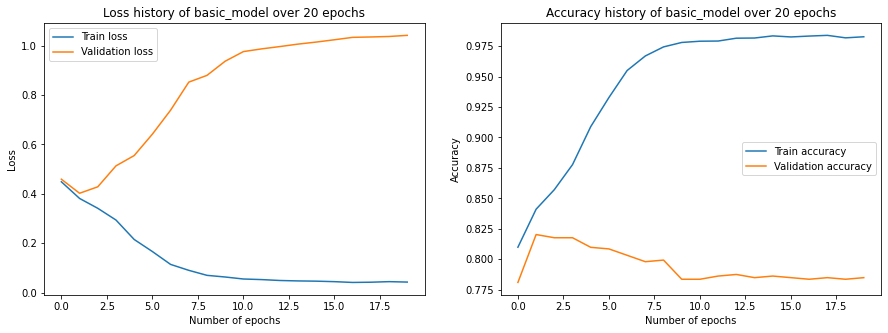

In [42]:
plot_training_results(history, 'basic_model')

# Classifier approaches 

### RandomForestClassifier

In [43]:
rfc = RandomForestClassifier(verbose=1)

In [44]:
rfc.fit(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.0s finished


RandomForestClassifier(verbose=1)

In [45]:
rfc.score(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.99722668223617

In [46]:
rfc.score(val_embeddings, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8149606299212598

### GradientBoostingClassifier

In [47]:
gbc = GradientBoostingClassifier(verbose=1)

In [48]:
gbc.fit(embeddings, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3177            3.78m
         2           1.2779            4.01m
         3           1.2436            3.84m
         4           1.2107            3.77m
         5           1.1823            3.76m
         6           1.1548            3.73m
         7           1.1313            3.75m
         8           1.1092            3.77m
         9           1.0896            3.84m
        10           1.0717            3.90m
        20           0.9350            3.69m
        30           0.8537            3.26m
        40           0.7977            2.92m
        50           0.7562            2.38m
        60           0.7235            1.88m
        70           0.6963            1.40m
        80           0.6721           55.27s
        90           0.6525           27.49s
       100           0.6353            0.00s


GradientBoostingClassifier(verbose=1)

In [49]:
gbc.score(embeddings, y_train)

0.8744708801634797

In [50]:
gbc.score(val_embeddings, y_val)

0.8241469816272966

# Hyperparameters tuning

In [51]:
param_grid = { 'n_estimators': [100, 300, 500, 1000],
               'max_depth': [300, 500, 1000]
              }

### RandomForestClassifier

In [52]:
grid = GridSearchCV(RandomForestClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  18.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  18.1s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  18.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  17.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  19.5s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   57.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=300; total time=  58.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   52.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  52.6s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=300; total time=  53.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   52.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV] END ....................max_depth=300, n_estimators=300; total time=  53.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   52.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=300; total time=  52.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 2.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 3.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 3.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 3.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=300, n_estimators=1000; total time= 3.0min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  18.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  17.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  18.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  18.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  17.3s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   54.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV] END ....................max_depth=500, n_estimators=300; total time=  55.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   52.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  52.4s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   51.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  51.2s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   48.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  48.8s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  37.9s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.3min


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.5min


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  13.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.4s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  36.9s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  36.5s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  36.7s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  36.8s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  36.8s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.0min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.0min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.0min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.0min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.7min finished


GridSearchCV(estimator=RandomForestClassifier(verbose=1),
             param_grid={'max_depth': [300, 500, 1000],
                         'n_estimators': [100, 300, 500, 1000]},
             verbose=2)

In [53]:
grid.best_params_

{'max_depth': 1000, 'n_estimators': 1000}

In [54]:
grid.best_estimator_.score(val_embeddings, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.8293963254593176

### GradientBoostingClassifier

Due to the time of computing needed to run GridSearchCV on GradientBoostingClassifier with our param_grid, we are going to use HalvingGridSearchCV and a reduced param_grid.

In [59]:
reduced_param_grid = { 'n_estimators': [100, 300],
                      'max_depth': [300, 500]
                     }

In [ ]:
grid = HalvingGridSearchCV(GradientBoostingClassifier(verbose=1), reduced_param_grid, verbose=2)

grid.fit(embeddings, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 2283
max_resources_: 6851
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 2283
Fitting 5 folds for each of 4 candidates, totalling 20 fits
      Iter       Train Loss   Remaining Time 
         1           1.1699            1.54m
         2           1.0159            1.51m
         3           0.8882            1.52m
         4           0.7807            1.51m
         5           0.6891            1.49m
         6           0.6102            1.47m
         7           0.5420            1.46m
         8           0.4824            1.45m
         9           0.4303            1.43m
        10           0.3845            1.42m
        20           0.1318            1.28m
        30           0.0474            1.09m
        40           0.0173           54.41s
        50           0.0063           44.63s
        60           0.0023           35.30s
        70        

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(val_embeddings, y_val)

# Fine-Tuning BertForSequenceClassification

In [ ]:
device = torch.device('mps')

In [ ]:
sentences = data.text.values
labels = data.target.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

In [ ]:
MAX_LEN = 84

#Padding the input to the max length that is 84
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
# Creating the attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Performing same steps on the attention masks
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
#Converting the input data to the tensor , which can be feeded to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = False, )

# Telling the model to run on GPU 
model.to(device)

In [ ]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Creating the helper function to have a watch on elapsed time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#Let's start the training process

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")